# Midterm Exam AI in Finance: 10.10.2022

This Jupyter Notebook contains the record of my approach towards the midterm exam. All needed data will be stored in the *midterm_exam* folder.
To install specific libraries, please run the bash command. This command will install respective packages if these are not present in your environment.
You'll need to have pip installed as well.

## Instructions

This is a dataset of a sample of consumer loans (P2P loans). The variables are:
- return        - is the return achieved on the loan by the lender in [% p.a.]
- aumount       - is the log size of the loan
- borrowerRate  - it's the annualized interest rate on the loans
- term          - it's the time in months for the duration of the loan
- AA, A, ..., E - credit rating from best (AA) to worst (E).
- income        - monthly income in USD of the borrower
- Employed      - 1 if employed, 0 otherwise
- selfEmployed  - 1 if self employed, 0 otherwise
- bankcardUtil  - 1 if used, 0 otherwise
- realEstateBalance - log of the real estate balance
- Time, Time2   - Linear time trend (in days from the first loan on the platform) and square of the time trend (divided by 10000).

The goal is to design a prediction model that will predict the returns of the loan. Think about
variables that you will use. You are encouraged also create your own variables. Your graded tasks are as follows:
1) Prepare a table with descriptive statistics and correlations for key variables (not necessarily all) that enter your model.
4 points

2) Propose at least 4 models to predict returns.
4 points

3) Evaluate models and suggest which approach to use in future. Explain your recommendation.
4 points

Report and describe your results in MS WORD: Show tables and figures. Upload the code separately.

Remaining 8 points are rewarded based on the following:
Apart from fulfilling the goal, you will be evaluated based on following criteria:
- if you submit a working code (I load the data and run your code without errors. Think about reproducibility) along your explanations. (0.5b)
- if you present Figures as well. (0.5b)
- if you select different types of models, but 4 is enough. (2b)
- if you use multiple loss functions. (0.5b)
- if you interpret your results correctly. (0.5b)
- if you create your own variables and consider different transformations. (4b)

## 1 Initialization

Run the pip install command if you don't have any of the required libraries installed

In [ ]:
## !pip install -r requirements.txt

In [ ]:
#  imports
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels as sm

#  seed
np.random.seed(42)
plt.rcParams["figure.figsize"] = (20,15)

In [ ]:
#  data
data_mt = pd.read_csv("./MT_D2.csv")

At first, I split the data into test- and train-set

In [ ]:
from sklearn.model_selection import train_test_split
data_test, data_train = train_test_split(data_mt, train_size=0.2)

In [ ]:
data = {'test': data_test, 'train': data_train}

For now, I will work only with the test data set and the train dat set will be further used for the evaluation

## 2 EDA

In [ ]:
data['train'].describe()

In [ ]:
data['train'].dtypes

In the next step, I remove outliers. I do employ a very basic approach where I simply drop all the observations where any of the features is of $z_{score} > 3.5$

In [ ]:
data['train'] = data['train'][(np.abs(stats.zscore(data['train'])) < 3.5).all(axis=1)]

In [ ]:
## See how much observation do we have left
data['train'].shape[0]/4000

We have about 85 % of observations left after the outliers have been dropped

In the next step, I produce a correlation matrix of our variables

In [ ]:
train_corr = pd.DataFrame(data['train'].corr())
train_corr

<AxesSubplot: >

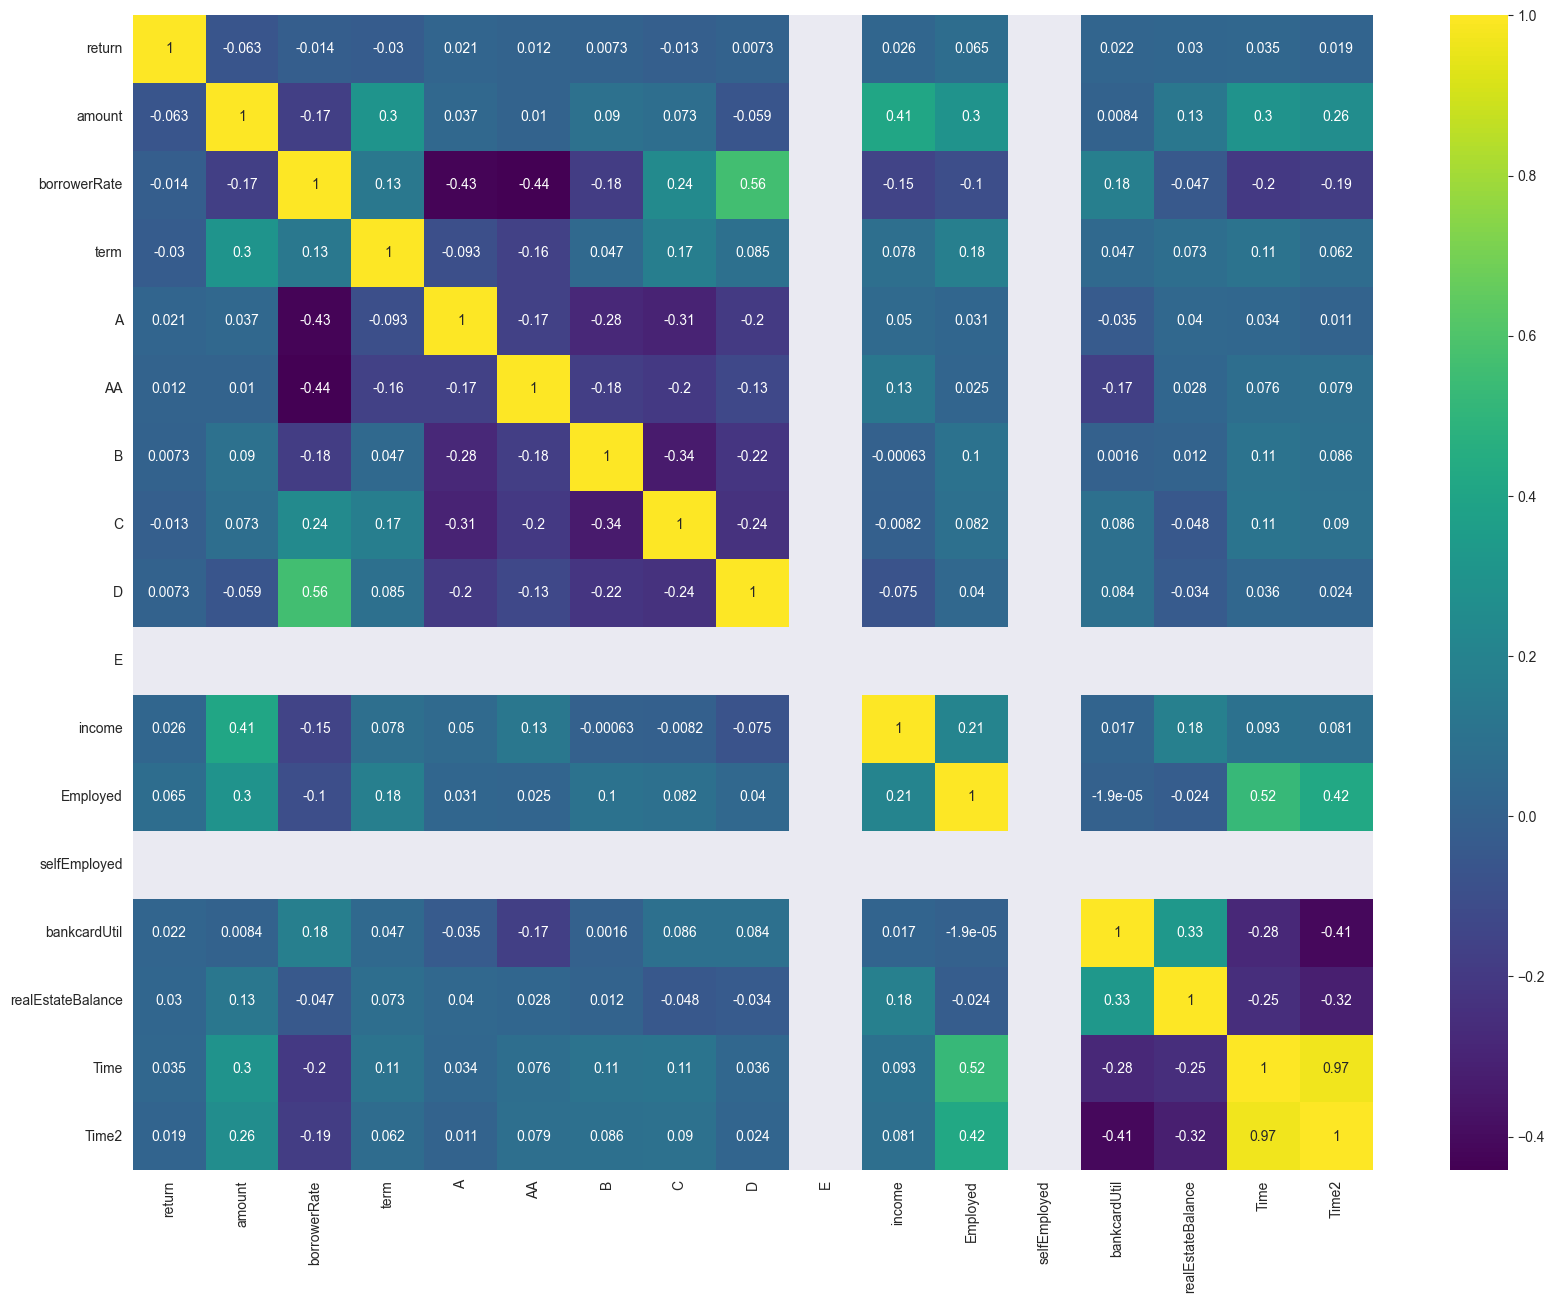

In [11]:
sns.heatmap(train_corr, annot=True, cmap="viridis")

We may observe that there is no significance between our target variable and the features. I will also remove the Time2 variable from our list of features as it would introduce multicollinearity with Time. I will also introduce an interaction term between the term and amount.

## 2 Modelling part

In [12]:
for key, val in data.items():
    val['amount_x_term'] = val['term'] * val['amount']

C:\Users\A200083283\AppData\Local\Temp\ipykernel_14024\2739099858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['amount_x_term'] = val['term'] * val['amount']


## 3 Modelling

In [13]:
features_selected = ['amount', 'borrowerRate', 'term', 'amount_x_term', 'income']

In [ ]:
sns.heatmap(data['train'][features_selected], annot=True, cmap="viridis")

<AxesSubplot: >

In [ ]:
X = data['train'][features_selected]
y = data['train']['return']

In [ ]:
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
models = {
    'm_lasso': LassoCV(),
    'm_enet': ElasticNetCV(),
    'm_ridge': RidgeCV(),
    'm_tree': DecisionTreeRegressor(),
    'm_rforr': RandomForestRegressor()
}

In [ ]:
fit_model = {}
for name, mod in models.items():
    fit_model[name] = mod.fit(X, y)

In [ ]:
pred_model = {}
for model, fit in fit_model.items():
    pred_model[model] = fit.predict(data['test'][features_selected])

In [ ]:
tbl_res = pd.melt(pd.DataFrame(pred_model, data['test']['return']).reset_index(), id_vars='return')
tbl_res

It might be useful to plot predictions against the actual value in test set

In [ ]:
sns.scatterplot(tbl_res, x='value', y='return', hue='variable', alpha=0.4)

In [ ]:
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
mse_score = {}
mape_score = {}
for model, fit in pred_model.items():
    mse_score[model] = mse(fit, data['test']['return'])
    mape_score[model] = mape(fit, data['test']['return'])

In [ ]:
mse_score

In [ ]:
pd.DataFrame(mse_score, index = ["mse"])

In [ ]:
pd.DataFrame(mape_score, index = ['mape'])

We can see that depending on the loss function,the best models actually differ. In terms of
their predictive ability, none of our models is actually very good. I could've spend more time on model tuning as well
as feature engineering.

# Conclusion

I have constructed total of 5 models without any fine tuning. I haven't reached very satisfying results as my feature engineering was very limited due to limited time